In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm

%run ../Scripts/trajectory.py
%run ../Scripts/trajectoryVisual.py
%run ../Scripts/trajsTree.py
%run ../Scripts/supMethods.py
foldername = "../Data/test4"

In [58]:
with open(foldername + "/params.json") as json_file:
    params = json.load(json_file)
with open(foldername + "/sim_params.json") as json_file:
    sim_params = json.load(json_file)

In [ ]:
i = 700
n_i = scipy.sparse.load_npz(foldername+f"/sp_frame_n{i}.npz").todok()
indexes = get_nonzero_w_repeats(n_i)
means_gmm, covs_gmm, counts_gmm = fit_unknown_GMM(indexes, w = 1000)
means, covs, counts = reduce_GMM(means_gmm, covs_gmm, counts_gmm)
plot_Ellipses(n_i, i, means, covs, save = False, foldername = foldername)

In [13]:
t0 = 300
tf = 2071
dt = 25
t_domain = np.arange(t0, tf, dt)

In [ ]:
for t in range(1000, 2071, 25):
    n_i = scipy.sparse.load_npz(foldername+f"/sp_frame_n{t}.npz").todok()
    indexes = get_nonzero_w_repeats(n_i)
    means_gmm, covs_gmm, counts_gmm = fit_unknown_GMM(indexes, w = 1000)
    means, covs, counts = reduce_GMM(means_gmm, covs_gmm, counts_gmm)
    plot_Ellipses(n_i, t, means, covs, save = True,
                foldername = foldername, input_color = "teal")
    
make_Gif(foldername, t_domain, typename = "GMM_plots")

In [15]:
make_Gif(foldername, t_domain, typename = "GMM_plots")

In [17]:
for t in range(1000, 2071, 25):
    n_i = scipy.sparse.load_npz(foldername+f"/sp_frame_n{t}.npz").todok()
    indexes = get_nonzero_w_repeats(n_i)
    means_gmm, covs_gmm, counts_gmm = fit_unknown_GMM(indexes, w = 1000)
    means, covs, counts = reduce_GMM(means_gmm, covs_gmm, counts_gmm)
    next_list = make_Treelist(t, means, covs, counts)
    
    if t == t0:
        init_list = next_list
        prev_list = next_list
        continue

    prev_list = link_Treelists(prev_list, next_list)
    prev_list = next_list

save_Treelist(foldername, init_list)
make_Gif(foldername, t_domain, typename = "GMM_plots")

/Users/zhizhang144515/opt/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


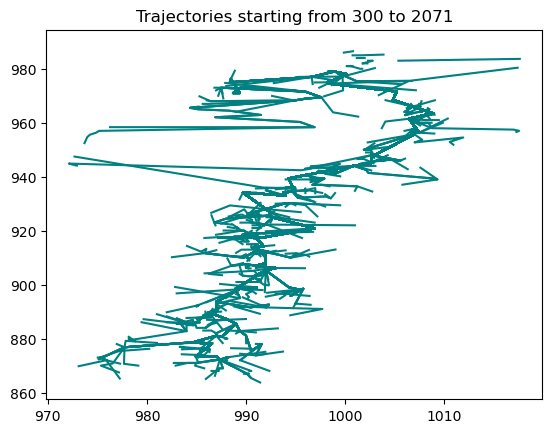

In [18]:
colors = generate_colors(len(init_list))
plt.figure()
plt.title(f"Trajectories starting from {t0} to {tf}")

for root_node, color in zip(init_list, colors):
    for trajs in root_node.get_all_traversals():
        try:
            positions = [x.mean for x in trajs]
            x_val, y_val = extract_xy(positions)
            plt.plot(x_val, y_val, color = "teal")
        except IndexError:
            print(positions)


/Users/zhizhang144515/Documents/CRISPR_Sim/Scripts/trajectory.py:171: RuntimeWarning: invalid value encountered in power
  v = np.power(s, 1/3)*np.power(D, 2/3)*np.power(common_log, 1/3)


Text(0, 0.5, 'velocity')

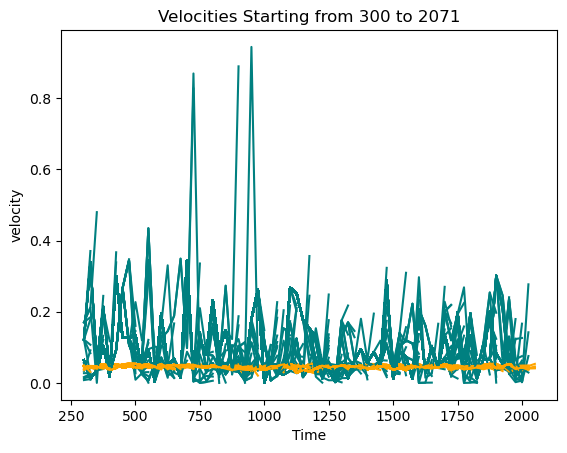

In [19]:
colors = generate_colors(len(init_list))
t_domain_np = np.array(t_domain)
plt.figure()
plt.title(f"Velocities Starting from {t0} to {tf}")

for root_node, color in zip(init_list, colors):
    for trajs in root_node.get_all_traversals():
        positions = [x.mean for x in trajs]
        counts = np.array([x.count for x in trajs])
        x_val, y_val = extract_xy(positions)
        if isinstance(x_val, np.ndarray):
            v_obs = np.sqrt(np.diff(x_val)**2 + np.diff(y_val)**2)/dt
            v_calc = calculate_velocity(counts, params, sim_params)
            plt.plot(t_domain_np[:len(v_obs)], v_obs, color = 'teal')
            plt.plot(t_domain_np[:len(v_calc)], v_calc, color = 'orange')

# plt.ylim(0, 0.2)
plt.xlabel("Time")
plt.ylabel("velocity")

Text(0, 0.5, 'velocity')

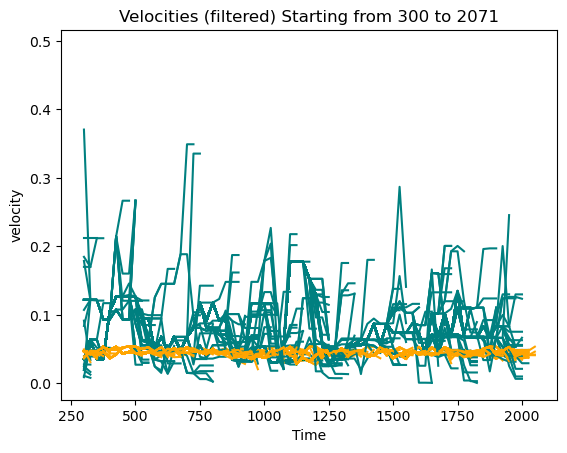

In [20]:
t_domain_np = np.array(t_domain)
plt.figure()
plt.title(f"Velocities (filtered) Starting from {t0} to {tf}")

for root_node, color in zip(init_list, colors):
    for trajs in root_node.get_all_traversals():
        positions = [x.mean for x in trajs]
        counts = np.array([x.count for x in trajs])
        x_val, y_val = extract_xy(positions)
        if isinstance(x_val, np.ndarray):
            v_obs = np.sqrt(np.diff(x_val)**2 + np.diff(y_val)**2)/dt
            v_obs_med = running_median_filter(v_obs, 5)
            v_calc = calculate_velocity(counts, params, sim_params)
            plt.plot(t_domain_np[:len(v_obs_med)], v_obs_med, color = 'teal')
            plt.plot(t_domain_np[:len(v_calc)], v_calc, color = 'orange')

# plt.ylim(0, 0.2)
plt.xlabel("Time")
plt.ylabel("velocity")

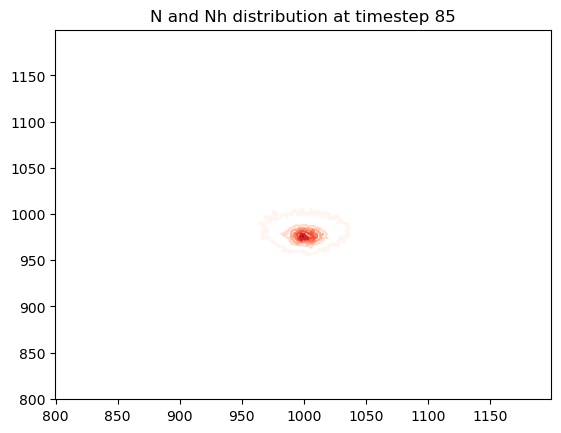

In [27]:
n_i = scipy.sparse.load_npz(f"../Data/test6sp_frame_n85.npz").todok()
margins = (-0.4, -0.4)
save = False
fig = plt.figure()
plt.contour(n_i.toarray().transpose(), cmap = "Reds")
# plt.contour(nh_i.toarray().transpose(), cmap = "Blues")
plt.margins(margins[0], margins[1])

plt.title(f"N and Nh distribution at timestep {85}")
if save:
    try:
        plt.savefig(f'{foldername}/time_plots/img_{i}.png', 
                    transparent = False, facecolor = 'white')
    except FileNotFoundError:
        os.mkdir(foldername+"/time_plots")
        plt.savefig(f'{foldername}/time_plots/img_{i}.png', 
                    transparent = False, facecolor = 'white')
    plt.close()

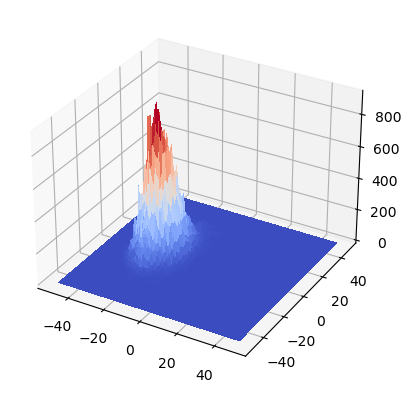

In [35]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x_dom = sim_params["xdomain"]
# Make data.
X = np.arange(-x_dom , x_dom , 1)[950:1050]
Y = np.arange(-x_dom , x_dom , 1)[950:1050]
X, Y = np.meshgrid(X, Y)
Z = n_i.toarray()[950:1050, 950:1050]

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [61]:
%run ../Scripts/fitness.py
%run ../Scripts/initMethods.py
%run ../Scripts/coverage.py

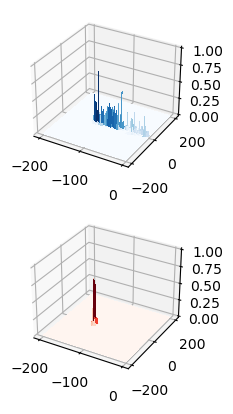

In [57]:
nh_i = scipy.sparse.load_npz(f"../Data/test4/sp_frame_nh{2000}.npz").todok()
n_i = scipy.sparse.load_npz(f"../Data/test4/sp_frame_n{2000}.npz").todok()
fig, ax = plt.subplots(2, subplot_kw={"projection": "3d"})

x_dom = sim_params["xdomain"]
# Make data.
X = np.arange(-x_dom , x_dom , 1)[800:1000]
Y = np.arange(-x_dom , x_dom , 1)[800:1200]
X, Y = np.meshgrid(X, Y)
Z = nh_i.toarray()[800:1200, 800:1000]
Z2 = n_i.toarray()[800:1200, 800:1000]

# Plot the surface.
surf = ax[0].plot_surface(X, Y, minmax_norm(Z), cmap="Blues",
                       linewidth=0, antialiased=False)
surf2 = ax[1].plot_surface(X, Y, minmax_norm(Z2), cmap="Reds",
                       linewidth=0, antialiased=False)
# ax.title("Immunity") 

In [62]:
kernel_quarter = init_quarter_kernel(params, sim_params)

p = elementwise_coverage(nh_i, n_i, kernel_quarter, params, sim_params)
f = fitness_spacers(n_i, nh_i, p, params, sim_params)

elementwise_coverage took 00:04:05


In [65]:
f.values()

<function dok_matrix.values>

(array([12., 28., 48., 53., 55., 53., 51., 51., 29., 10.]),
 array([2.89596602, 2.89606213, 2.89615824, 2.89625435, 2.89635046,
        2.89644656, 2.89654267, 2.89663878, 2.89673489, 2.896831  ,
        2.89692711]),
 <BarContainer object of 10 artists>)

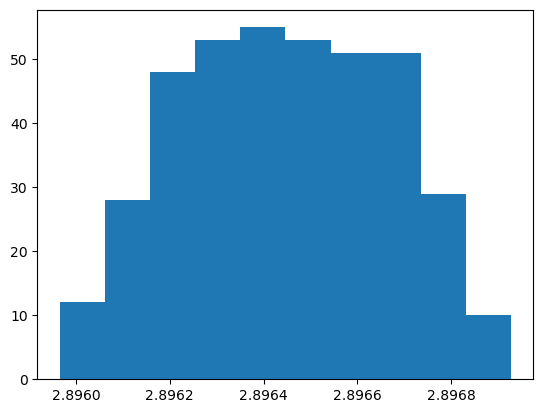

In [67]:
plt.hist(f.values())

(array([12., 28., 48., 53., 55., 53., 51., 51., 29., 10.]),
 array([-5.04033006e-04, -4.07924844e-04, -3.11816682e-04, -2.15708520e-04,
        -1.19600358e-04, -2.34921966e-05,  7.26159651e-05,  1.68724127e-04,
         2.64832289e-04,  3.60940450e-04,  4.57048612e-04]),
 <BarContainer object of 10 artists>)

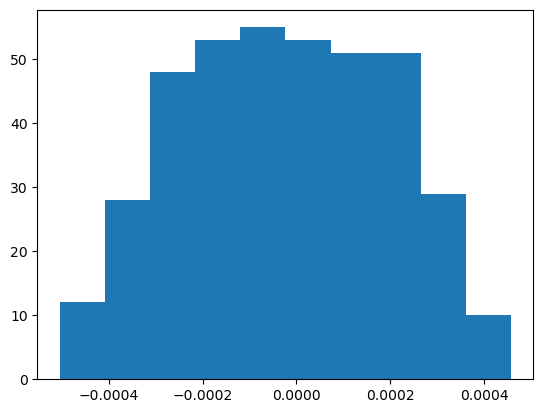

In [68]:
f_norm = norm_fitness(f, n_i, params, sim_params)

plt.hist(f_norm.values())

In [78]:
approx_p = pred_value(params, sim_params)

Text(0.5, 1.0, 'Fitness Theory')

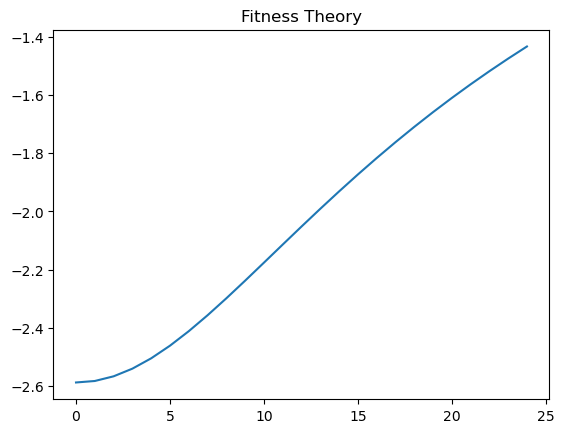

In [80]:
X = np.arange(-x_dom , x_dom , 1)[1000:1025]
R0 = params["R0"]
approx_f = np.log(R0*(1-approx_p(X)))

plt.plot(X, approx_f)
plt.title("Fitness Theory")